In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report
import matplotlib.pyplot as plt

## 1. Descarga y prepara los datos.  Explica el procedimiento.

In [15]:
# Cargar el dataset
df = pd.read_csv("/datasets/Churn.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [16]:
#Algo de limpieza:

df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df['Tenure'].fillna(df['Tenure'].median(), inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


## 2. Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.

In [17]:
features = df.drop(columns=['Exited'])
target = df['Exited']


features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)


# Examinar equilibrio de clases
print("Distribución de clases en el conjunto completo:")
print(target.value_counts())
print("\nProporción de clases (%):")
print(target.value_counts(normalize=True) * 100)

Distribución de clases en el conjunto completo:
0    7963
1    2037
Name: Exited, dtype: int64

Proporción de clases (%):
0    79.63
1    20.37
Name: Exited, dtype: float64


In [18]:
# Entrenar modelo sin tener en cuenta el desequilibrio

model = LogisticRegression(max_iter=5000, random_state=12345)
model.fit(features_train, target_train)




# Evaluar en el conjunto de prueba
y_pred = model.predict(features_test)
y_proba = model.predict_proba(features_test)[:, 1]


AUC-ROC: 0.6719
F1 Score: 0.1078

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      1965
           1       0.43      0.06      0.11       535

    accuracy                           0.78      2500
   macro avg       0.61      0.52      0.49      2500
weighted avg       0.71      0.78      0.71      2500



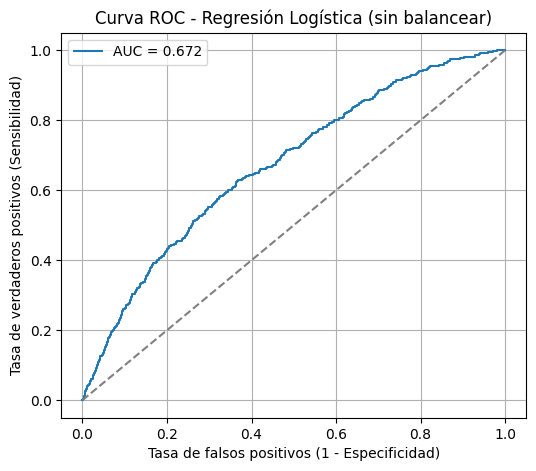

In [19]:
auc = roc_auc_score(target_test, y_proba)
f1 = f1_score(target_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(target_test, y_pred))

# Curva ROC visual ---
fpr, tpr, thresholds = roc_curve(target_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)")
plt.ylabel("Tasa de verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística (sin balancear)")
plt.legend()
plt.grid(True)
plt.show()

#### AUC-ROC: 0.6711
#### F1 Score: 0.1438
Sin  tener en cuenta el desequilbrio

## 3. Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.

AUC-ROC: 0.7566
F1 Score: 0.4893

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      1965
           1       0.37      0.70      0.49       535

    accuracy                           0.69      2500
   macro avg       0.63      0.69      0.63      2500
weighted avg       0.78      0.69      0.71      2500



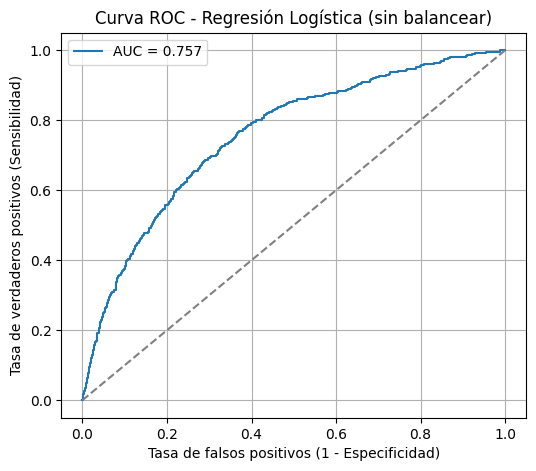

In [21]:
# Lo primero que hacemos es hacer el modelo balanceado
model_balanced = LogisticRegression(
    random_state=12345, solver='liblinear', class_weight='balanced')
model_balanced.fit(features_train, target_train)

# Evaluar en el conjunto de prueba
y_pred = model_balanced.predict(features_test)
y_proba = model_balanced.predict_proba(features_test)[:, 1]

auc = roc_auc_score(target_test, y_proba)
f1 = f1_score(target_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(target_test, y_pred))

# Curva ROC visual ---
fpr, tpr, thresholds = roc_curve(target_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)")
plt.ylabel("Tasa de verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística (sin balancear)")
plt.legend()
plt.grid(True)
plt.show()

In [32]:

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    f1 = f1_score(target_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Mejor umbral: {best_threshold:.2f}")
print(f"Mejor F1 Score: {best_f1:.4f}")

y_pred_best = (y_proba >= best_threshold).astype(int)

print("\nNuevo reporte con umbral optimizado:")
print(classification_report(target_test, y_pred_best))


Mejor umbral: 0.56
Mejor F1 Score: 0.5122

Nuevo reporte con umbral optimizado:
              precision    recall  f1-score   support

           0       0.88      0.77      0.83      1965
           1       0.43      0.63      0.51       535

    accuracy                           0.74      2500
   macro avg       0.66      0.70      0.67      2500
weighted avg       0.79      0.74      0.76      2500



AUC-ROC: 0.7632
F1 Score: 0.5047

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1965
           1       0.39      0.70      0.50       535

    accuracy                           0.70      2500
   macro avg       0.65      0.70      0.65      2500
weighted avg       0.79      0.70      0.73      2500



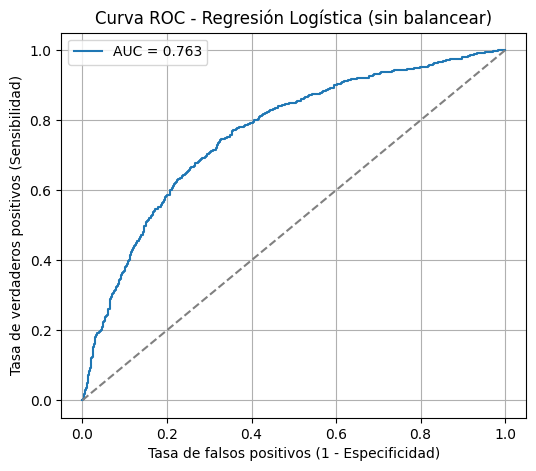

In [33]:
# le agrego el penalty = L1
model_balanced = LogisticRegression(
    random_state=12345, solver='liblinear', class_weight='balanced',penalty='l1')
model_balanced.fit(features_train, target_train)

# Evaluar en el conjunto de prueba
y_pred = model_balanced.predict(features_test)
y_proba = model_balanced.predict_proba(features_test)[:, 1]

auc = roc_auc_score(target_test, y_proba)
f1 = f1_score(target_test, y_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(target_test, y_pred))

# Curva ROC visual ---
fpr, tpr, thresholds = roc_curve(target_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)")
plt.ylabel("Tasa de verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística (sin balancear)")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    f1 = f1_score(target_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Mejor umbral: {best_threshold:.2f}")
print(f"Mejor F1 Score: {best_f1:.4f}")

y_pred_best = (y_proba >= best_threshold).astype(int)

print("\nNuevo reporte con umbral optimizado:")
print(classification_report(target_test, y_pred_best))


Mejor umbral: 0.56
Mejor F1 Score: 0.5122

Nuevo reporte con umbral optimizado:
              precision    recall  f1-score   support

           0       0.88      0.77      0.83      1965
           1       0.43      0.63      0.51       535

    accuracy                           0.74      2500
   macro avg       0.66      0.70      0.67      2500
weighted avg       0.79      0.74      0.76      2500



AUC-ROC: 0.7632
F1 Score (umbral 0.56): 0.5122

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.77      0.83      1965
           1       0.43      0.63      0.51       535

    accuracy                           0.74      2500
   macro avg       0.66      0.70      0.67      2500
weighted avg       0.79      0.74      0.76      2500



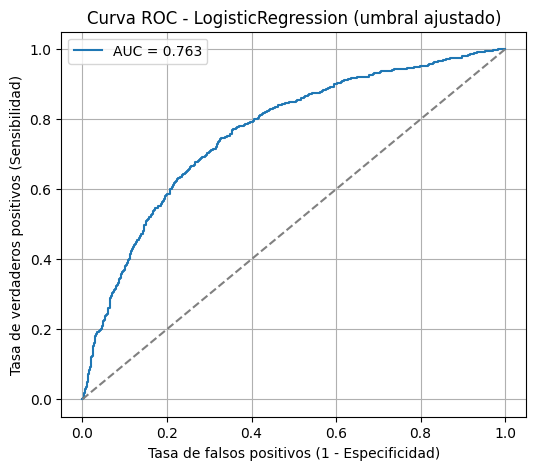

In [35]:
# Entrenar el modelo (ya lo tienes hecho)
model_balanced.fit(features_train, target_train)

# Probabilidades del conjunto de prueba
y_proba = model_balanced.predict_proba(features_test)[:, 1]

# Aplicar tu umbral óptimo (0.56)
threshold = 0.56
y_pred = (y_proba >= threshold).astype(int)

# Evaluar con el nuevo umbral
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve

f1 = f1_score(target_test, y_pred)
auc = roc_auc_score(target_test, y_proba)

print(f"AUC-ROC: {auc:.4f}")
print(f"F1 Score (umbral {threshold}): {f1:.4f}")
print("\nReporte de clasificación:")
print(classification_report(target_test, y_pred))

# Curva ROC
fpr, tpr, _ = roc_curve(target_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)")
plt.ylabel("Tasa de verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC - LogisticRegression (umbral ajustado)")
plt.legend()
plt.grid(True)
plt.show()
